In [1]:
from functools import partial
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tqdm.auto import tqdm

In [2]:
#https://www.kaggle.com/code/prasadchaskar/diamond-price-regression-eda

In [3]:
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

diamond_df = pd.read_csv('diamonds.csv')
diamond_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
diamond_df.shape

(53940, 10)

In [5]:
diamond_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
diamond_df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [7]:
X = diamond_df.drop(['price'], axis=1)
y = diamond_df['price']

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape)

(43152, 9) (10788, 9)


In [8]:
label_encoder = LabelEncoder()

X_train['cut'] = label_encoder.fit_transform(X_train['cut'])
X_test['cut'] = label_encoder.transform(X_test['cut'])

X_train['color'] = label_encoder.fit_transform(X_train['color'])
X_test['color'] = label_encoder.transform(X_test['color'])

X_train['clarity'] = label_encoder.fit_transform(X_train['clarity'])
X_test['clarity'] = label_encoder.transform(X_test['clarity'])

In [9]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


In [10]:
from itertools import product

ModelType = KNeighborsRegressor | LinearRegression | Ridge | Lasso | DecisionTreeRegressor \
        | RandomForestRegressor | SVR | AdaBoostRegressor | GradientBoostingRegressor

ModelClsType = type[KNeighborsRegressor] | type[LinearRegression] | type[Ridge] | type[Lasso] | type[DecisionTreeRegressor] \
        | type[RandomForestRegressor] | type[SVR] | type[AdaBoostRegressor] | type[GradientBoostingRegressor]

dict_list_args:dict[ModelClsType, list[dict]] = {
        KNeighborsRegressor:[dict(n_neighbors=n, weights="distance", p=p) for n,p in product([5, 10, 20, 40, 80], [1,2,3])],
        LinearRegression:[dict()],
        Ridge:[dict(alpha=10**alpha) for alpha in range(-5, 3)],
        Lasso:[dict(alpha=10**alpha) for alpha in range(-8, 1)],
        DecisionTreeRegressor:[dict(min_samples_leaf=min_samples_leaf) for min_samples_leaf in range(1, 5)],
        RandomForestRegressor:[dict(n_estimators=n_estimators) for n_estimators in [10, 25, 50, 100]],
        SVR:[dict(C=C, kernel=kernel) for C, kernel in product(np.linspace(0.1, 1., 4), ['linear', 'rbf', 'sigmoid'])],
        AdaBoostRegressor:[dict(estimator=estimator, n_estimators=100) for estimator in [None, SVR()]],
        GradientBoostingRegressor:[dict(learning_rate=learning_rate) for learning_rate in [1e-3, 1e-2, 1e-1]]
        }

In [11]:
results:dict[ModelClsType, dict] = {}
for model_cls, args_list in tqdm(dict_list_args.items()):
    
    best_r2 = best_mae = best_rmse = float("inf")
    best_args = None
    best_model = None
    for args in (pbar:=tqdm(args_list, leave=False)):
        try:
            model = model_cls(random_state=42, **args)
        except TypeError:
            model = model_cls(**args)
        model.fit(X=X_train_scaled, y=y_train)
        
        y_pred = model.predict(X_test_scaled)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        
        pbar.desc = f"{args}: mae:{mae:.2f}, rmse:{rmse:.2f}, r2:{r2:.2f}"
        
        if rmse <= best_rmse:
            best_rmse = rmse
            best_mae = mae
            best_r2 = r2
            best_args = args
            best_model = model
    
    results[model_cls] = dict(best_rmse=best_rmse, best_mae=best_mae, best_r2=best_r2, best_args=best_args, best_model=best_model)
        
    print(f"""{model_cls.__name__} has best fit when {best_args}, and rmse:{best_rmse:.2f}, mae:{best_mae:.2f}, r2:{best_r2:.2f}""")

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

KNeighborsRegressor has best fit when {'n_neighbors': 5, 'weights': 'distance', 'p': 1}, and rmse:719.65, mae:351.57, r2:0.97


  0%|          | 0/1 [00:00<?, ?it/s]

LinearRegression has best fit when {}, and rmse:1337.92, mae:859.18, r2:0.89


  0%|          | 0/8 [00:00<?, ?it/s]

Ridge has best fit when {'alpha': 1e-05}, and rmse:1337.92, mae:859.18, r2:0.89


  0%|          | 0/9 [00:00<?, ?it/s]

Lasso has best fit when {'alpha': 1e-08}, and rmse:1337.92, mae:859.18, r2:0.89


  0%|          | 0/4 [00:00<?, ?it/s]

DecisionTreeRegressor has best fit when {'min_samples_leaf': 4}, and rmse:672.05, mae:329.47, r2:0.97


  0%|          | 0/4 [00:00<?, ?it/s]

RandomForestRegressor has best fit when {'n_estimators': 100}, and rmse:541.12, mae:266.42, r2:0.98


  0%|          | 0/12 [00:00<?, ?it/s]

SVR has best fit when {'C': 1.0, 'kernel': 'linear'}, and rmse:1579.13, mae:880.40, r2:0.84


  0%|          | 0/2 [00:00<?, ?it/s]

AdaBoostRegressor has best fit when {'estimator': None, 'n_estimators': 100}, and rmse:1265.27, mae:938.14, r2:0.90


  0%|          | 0/3 [00:00<?, ?it/s]

GradientBoostingRegressor has best fit when {'learning_rate': 0.1}, and rmse:671.39, mae:366.16, r2:0.97


In [12]:
results.keys()

dict_keys([<class 'sklearn.neighbors._regression.KNeighborsRegressor'>, <class 'sklearn.linear_model._base.LinearRegression'>, <class 'sklearn.linear_model._ridge.Ridge'>, <class 'sklearn.linear_model._coordinate_descent.Lasso'>, <class 'sklearn.tree._classes.DecisionTreeRegressor'>, <class 'sklearn.ensemble._forest.RandomForestRegressor'>, <class 'sklearn.svm._classes.SVR'>, <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>])

In [16]:
from sklearn.inspection import permutation_importance
def get_feature_importances(model:ModelType, model_args:dict) -> np.ndarray:
    if isinstance(model, KNeighborsRegressor):
        ret = KNN_FI(model)
    elif isinstance(model, (LinearRegression, Ridge, Lasso)):
        ret = LR_FI(model)
    elif isinstance(model, (DecisionTreeRegressor, RandomForestRegressor)):
        ret = DT_FI(model)
    elif isinstance(model, SVR):
        ret = SVR_FI(model, model_args)
    elif isinstance(model, (AdaBoostRegressor, GradientBoostingRegressor)):
        ret = Boost_FI(model)
    else:
        raise NotImplementedError
    return ret.flatten()
    
def KNN_FI(model:KNeighborsRegressor):
    return np.array(permutation_importance(model, X_test, y_test, n_jobs=-1)["importances_mean"])

def LR_FI(model:LinearRegression | Ridge | Lasso):
    coef = model.coef_
    return coef

def DT_FI(model:DecisionTreeRegressor | RandomForestRegressor):
    return model.feature_importances_

def SVR_FI(model:SVR, model_args:dict):
    match model_args["kernel"]:
        case 'linear':
            return model.coef_
        #Permutation Importance https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
        case ['rbf', 'sigmoid']:
            return np.array(permutation_importance(model, X_test, y_test, n_jobs=-1)["importances_mean"])
        case _:
            raise NotImplementedError

def Boost_FI(model:AdaBoostRegressor | GradientBoostingRegressor):
    return model.feature_importances_

In [27]:
for i, (k, v) in enumerate(results.items()):
    best_rmse=v["best_rmse"]
    best_mae=v["best_mae"]
    best_r2=v["best_r2"]
    best_args=v["best_args"]
    print(f"{k.__name__}")
    print(f"best_rmse: {best_rmse}")
    print(f"best_mae: {best_mae}")
    print(f"best_r2: {best_r2}")
    print()

KNeighborsRegressor
best_rmse: 719.6538642913052
best_mae: 351.5731385224848
best_r2: 0.9673282785689129

LinearRegression
best_rmse: 1337.922279650892
best_mae: 859.1800218691934
best_r2: 0.8870759447815817

Ridge
best_rmse: 1337.9222798483295
best_mae: 859.1800228524259
best_r2: 0.8870759447482532

Lasso
best_rmse: 1337.922279654021
best_mae: 859.1800218793381
best_r2: 0.8870759447810536

DecisionTreeRegressor
best_rmse: 672.0512518746543
best_mae: 329.4672279163798
best_r2: 0.9715075704678512

RandomForestRegressor
best_rmse: 541.1196291882193
best_mae: 266.4173067661158
best_r2: 0.9815281126825509

SVR
best_rmse: 1579.133128566635
best_mae: 880.4001302410737
best_r2: 0.8426878801654613

AdaBoostRegressor
best_rmse: 1265.266849424174
best_mae: 938.1352145730007
best_r2: 0.8990075395424465

GradientBoostingRegressor
best_rmse: 671.3937102921192
best_mae: 366.15546590888994
best_r2: 0.9715632977413858



0it [00:00, ?it/s]

/home/sizzflair97/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/sizzflair97/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/sizzflair97/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/sizzflair97/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/sizzflair97/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/sizzflair

[ 1.98448425e-01 -2.48813039e-03 -2.17945972e-03  6.55780860e-03
 -2.17348092e-06  8.32111243e-05 -2.68533885e-04 -2.75003335e-04
 -8.48587334e-04]


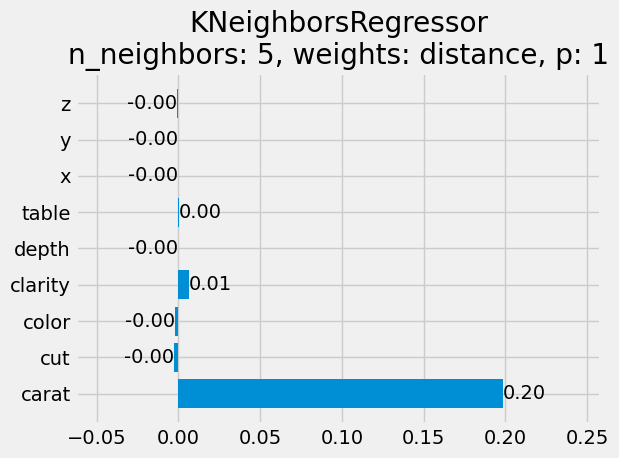

[ 5180.09779578    70.68212817  -453.07426287   498.93964582
  -224.37786368  -215.36321657 -1275.27652704    33.97983534
    -8.21568531]


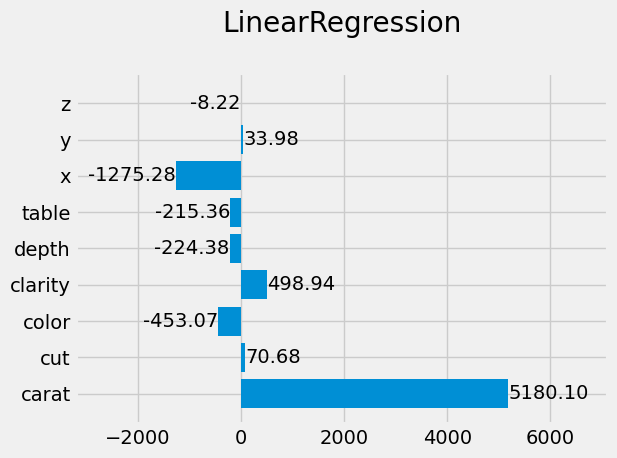

[ 5180.09776323    70.68212836  -453.07426196   498.93964606
  -224.37786127  -215.36321638 -1275.27648725    33.9798321
    -8.21569027]


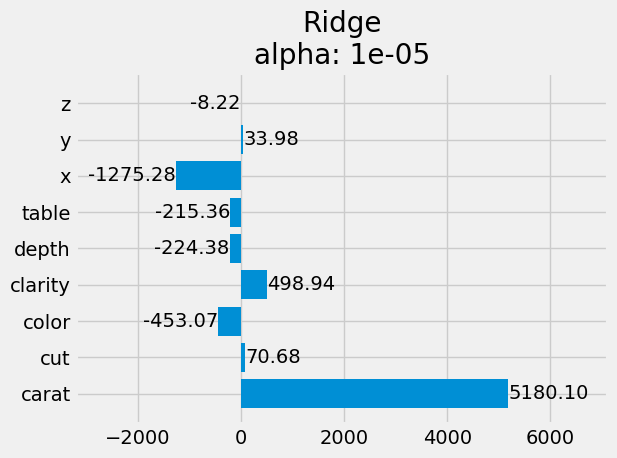

[ 5180.09779534    70.68212817  -453.07426285   498.93964581
  -224.37786365  -215.36321655 -1275.27652635    33.97983503
    -8.21568528]


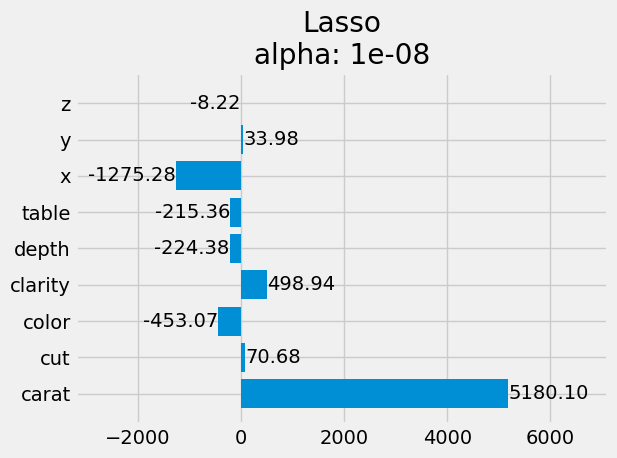

[0.63180782 0.00113517 0.02752683 0.06731624 0.0021862  0.00164385
 0.00236008 0.26272247 0.00330135]


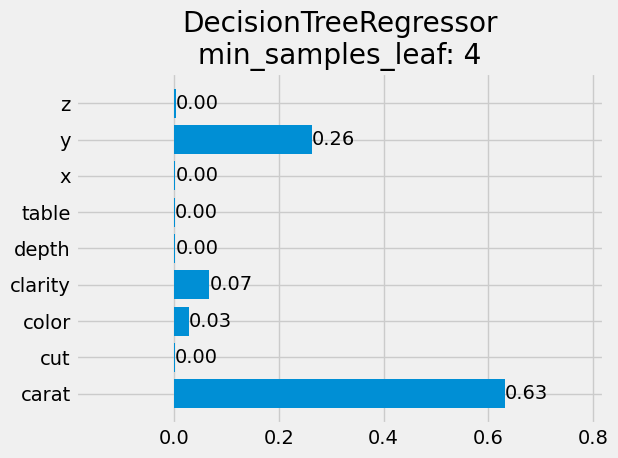

[0.60958467 0.00146893 0.02900558 0.0656188  0.00325143 0.00259373
 0.00463852 0.27867536 0.00516299]


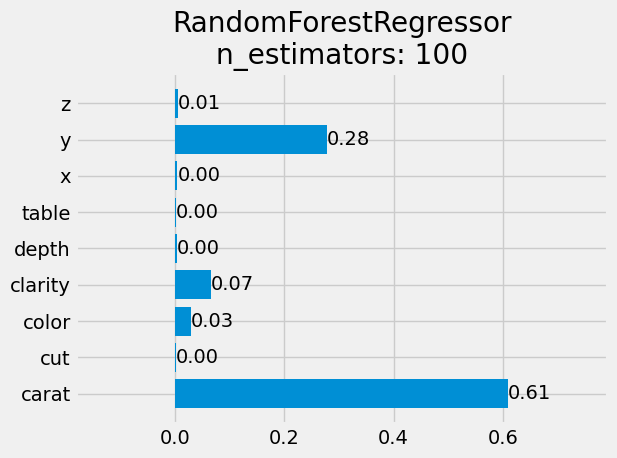

[ 3.22228406e+03  4.42135999e+01 -1.75359076e+02  2.67370690e+02
 -6.39767104e+01 -8.79884676e+01 -2.16750796e+00  1.30665329e+01
 -2.75010302e+00]


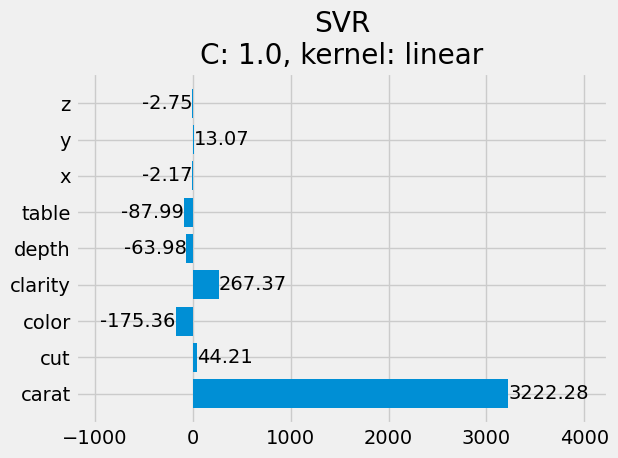

[0.35896965 0.00251336 0.07680552 0.30448459 0.00745296 0.00230852
 0.03436483 0.16504084 0.04805973]


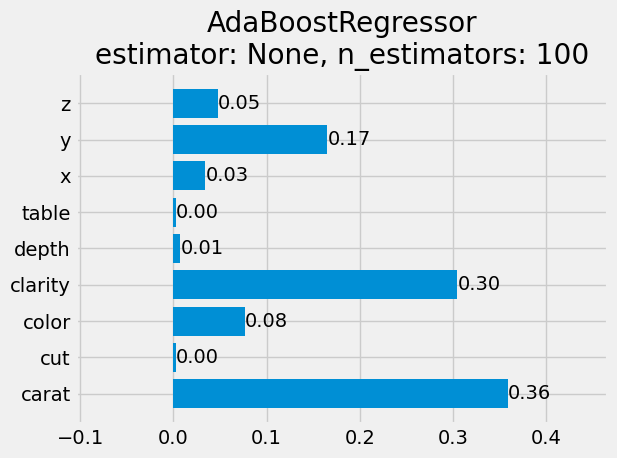

[2.72239062e-01 7.00253465e-04 2.64775116e-02 5.33120593e-02
 3.55141351e-04 8.05596256e-05 5.55515171e-03 6.08051111e-01
 3.32291497e-02]


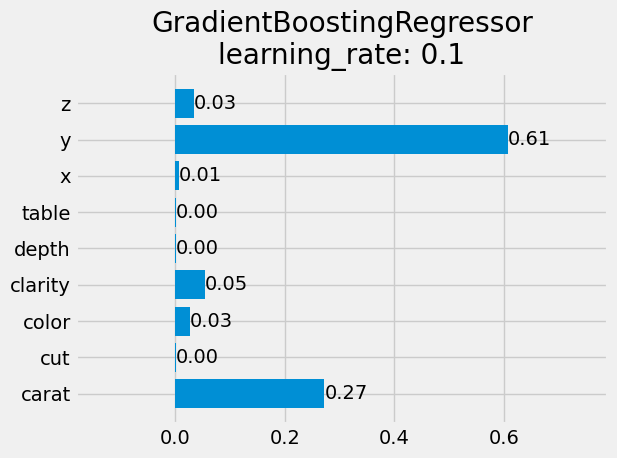

In [25]:
for i, (k, v) in tqdm(enumerate(results.items())):
    best_rmse=v["best_rmse"]
    best_mae=v["best_mae"]
    best_r2=v["best_r2"]
    best_args=v["best_args"]
    best_model=v["best_model"]
    
    if (feature_importances := get_feature_importances(best_model, best_args)) is None: continue
    
    print(feature_importances)
    plt.title(f"{k.__name__}\n{', '.join([f'{kp}: {vp}' for kp, vp in best_args.items()])}")
    # plt.barh(y=range(len(feature_importances)), width=feature_importances)
    bar = plt.barh(y=X.columns.to_list(), width=feature_importances)
    pad = 0.3 * (max(feature_importances) - min(feature_importances))
    plt.xlim(min(feature_importances)-pad, max(feature_importances)+pad)
    # plt.yticks(ticks=range(len(feature_importances)), labels=X.columns.to_list(), rotation=45)
    plt.bar_label(bar, fmt="%.2f")
    plt.tight_layout()
    plt.show()